In [3]:
import numpy as np
import os
import pickle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas.io.data as web
%matplotlib inline

## Here are all of our methods that create the various datapoints on our pandas DataFrame

In [4]:
class Name():
    def __init__(self, means, sd):
        self.mean1 = str(means[0])+"hr"
        self.mean2 = str(means[1])+"hr"
        self.name = self.mean1+"-"+self.mean2
        self.sd = sd
        self.strategy = "Strategy-{}-%.1f".format(self.name) % sd
        self.regime = "Regime-{}-%.1f".format(self.name) % sd
        self.cumsum = "Cumulative-{}-%.1f".format(self.name) % sd
    
    @classmethod
    def from_strategy_name(cls, strat):
        parts = strat.split('-')
        return cls([p.rstrip("hr") for p in parts[1:3]],float(parts[3]))
                

def get_dataframe():
    mydata = None
    try:
        mydata = pickle.load(open('modelling/stats_pickle5', 'rb'))
    except:
        mydata = pickle.load(open('../resources/stats_pickle5', 'rb'))
    df = pd.DataFrame(mydata, columns=["Time", "Value"])
    df = df.set_index('Time')
    return df
    
def create_means(df, means):
    for mean in means:
        df[str(mean)+"hr"] = np.round(pd.rolling_mean(df['Value'], window=mean*60), 2)

def create_diff(dataframe, name):
        dataframe[name.name] = dataframe[name.mean1] - dataframe[name.mean2]

def create_regime(dataframe, name):
    dataframe[name.regime] = np.where(dataframe[name.name] > name.sd, 1, 0)
    dataframe[name.regime] = np.where(dataframe[name.name] < -name.sd, -1, dataframe[name.regime])

def set_market(dataframe):
    dataframe['Market'] = np.log(dataframe['Value']/ dataframe['Value'].shift(1))
    dataframe['Market-cumulative'] = dataframe['Market'].cumsum().apply(np.exp)

def create_strategy(dataframe, name):
    dataframe[name.strategy] = dataframe[name.regime].shift(5) * dataframe['Market']

def create_cumsum(dataframe, name):
    dataframe[name.cumsum] = dataframe[name.strategy].cumsum().apply(np.exp)

#The does all of the basic setup and creates a graph that spans the whole of our available data.

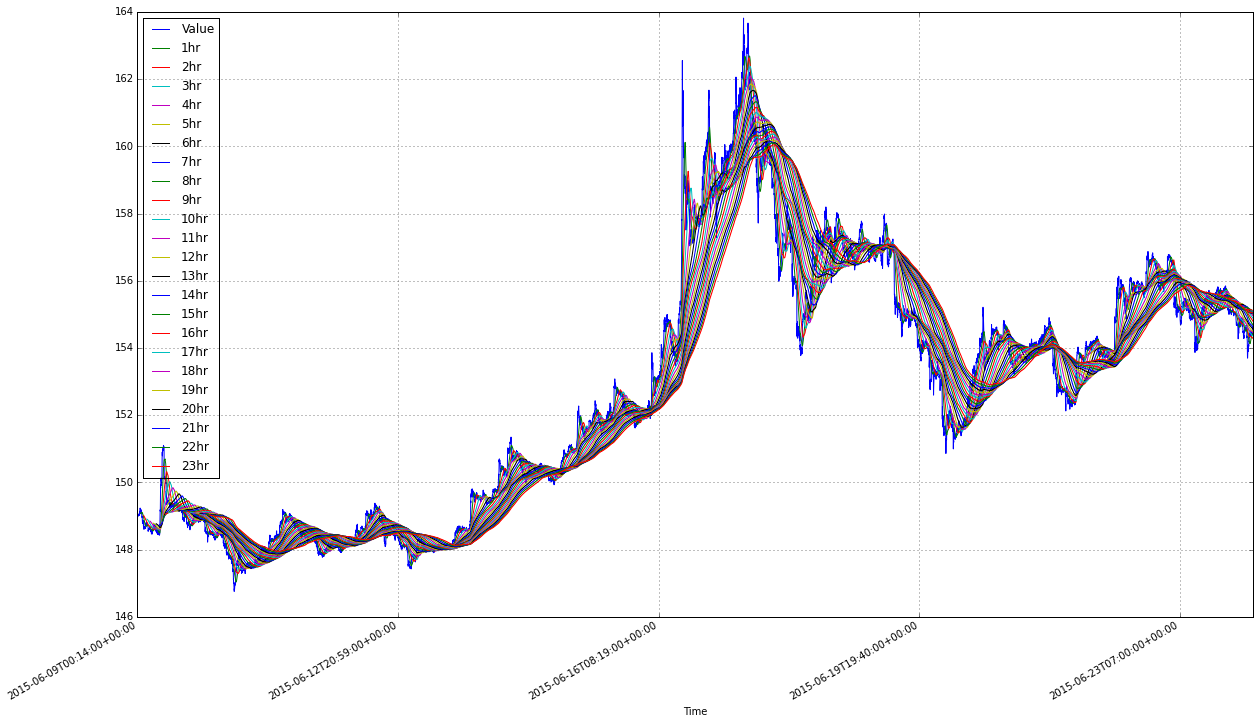

In [20]:
means = range(1,24)
SDs = np.arange(0.1,1,0.1)
df = get_dataframe()
create_means(df,means)
df.tail()
plot_means = df.plot(grid=True, figsize=(20,12))
plot_means.get_figure().autofmt_xdate()

# Set our market cumulation axes and then do the same for each of our strategies

In [22]:
set_market(df)
regime_and_strategy_names = [Name(means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
for name in regime_and_strategy_names:
    create_diff(df,name)
    create_regime(df, name)
    create_strategy(df,name)
    #create_cumsum(df, name)

In [24]:
df[['1hr-23hr','22hr-23hr']].tail()
#df3 = df[[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp) - self.strategies.cumsum().apply(np.exp).shift(hours*60)

,1hr-23hr,22hr-23hr
Time,,
2015-06-24T06:31:00+00:00,-0.59,-0.01
2015-06-24T06:33:00+00:00,-0.59,-0.01
2015-06-24T06:34:00+00:00,-0.58,-0.01
2015-06-24T06:35:00+00:00,-0.58,-0.01
2015-06-24T06:36:00+00:00,-0.58,-0.02


['Market', 'Strategy-5hr-19hr-0.3', 'Strategy-8hr-9hr-0.1', 'Strategy-3hr-6hr-0.1', 'Strategy-3hr-5hr-0.1']


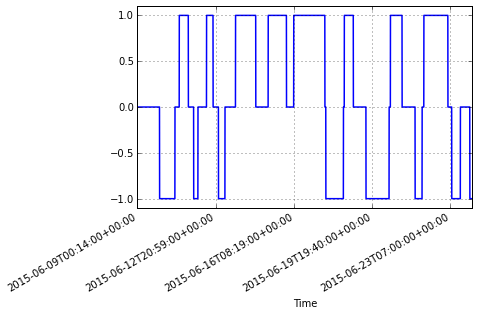

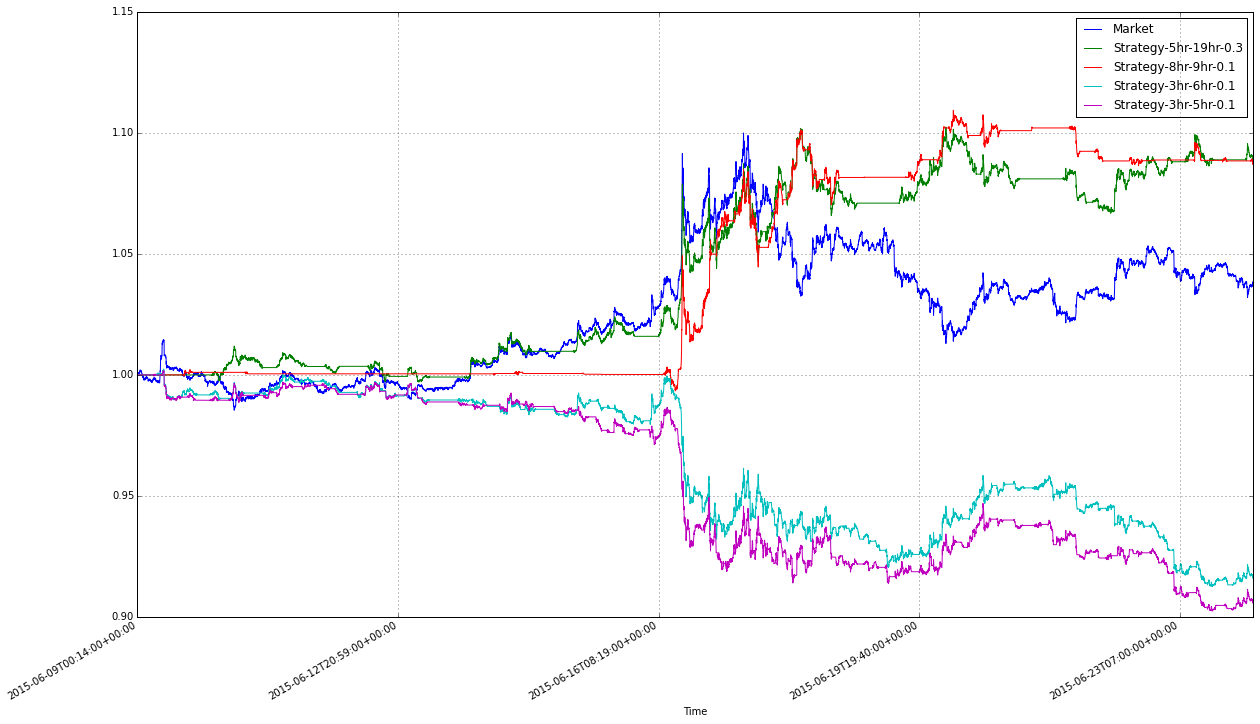

In [8]:
df2 = df[[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market']+df2[:2].index.tolist()+df2[-2:].index.tolist()
print(column_names)
i = df2[:1].index.tolist()[0]
plota = df[Name.from_strategy_name(i).regime].plot(lw=1.5)
plota.set_ylim([-1.1,1.1])
plota.get_figure().autofmt_xdate()

# df[column_names].tail
plotb = df[column_names].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))
# plotb = df[column_names].plot(grid=True, figsize=(40,25))

plotb.get_figure().autofmt_xdate()

#Data for 1 day (best and worst outcomes)

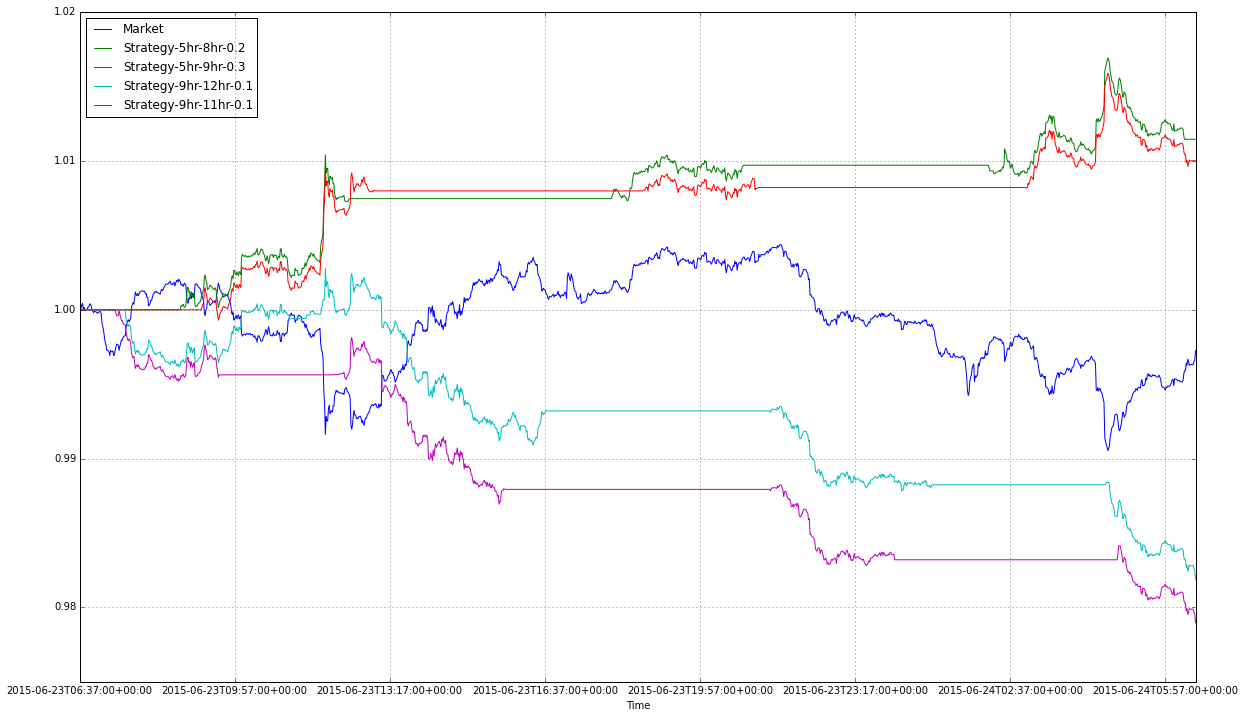

In [9]:
df[-1440:]
last_24 = df[-1440:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market']+last_24[:2].index.tolist()+last_24[-2:].index.tolist()
plotb = df[-1440:][column_names].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))

#Data for 2 days (best and worst)

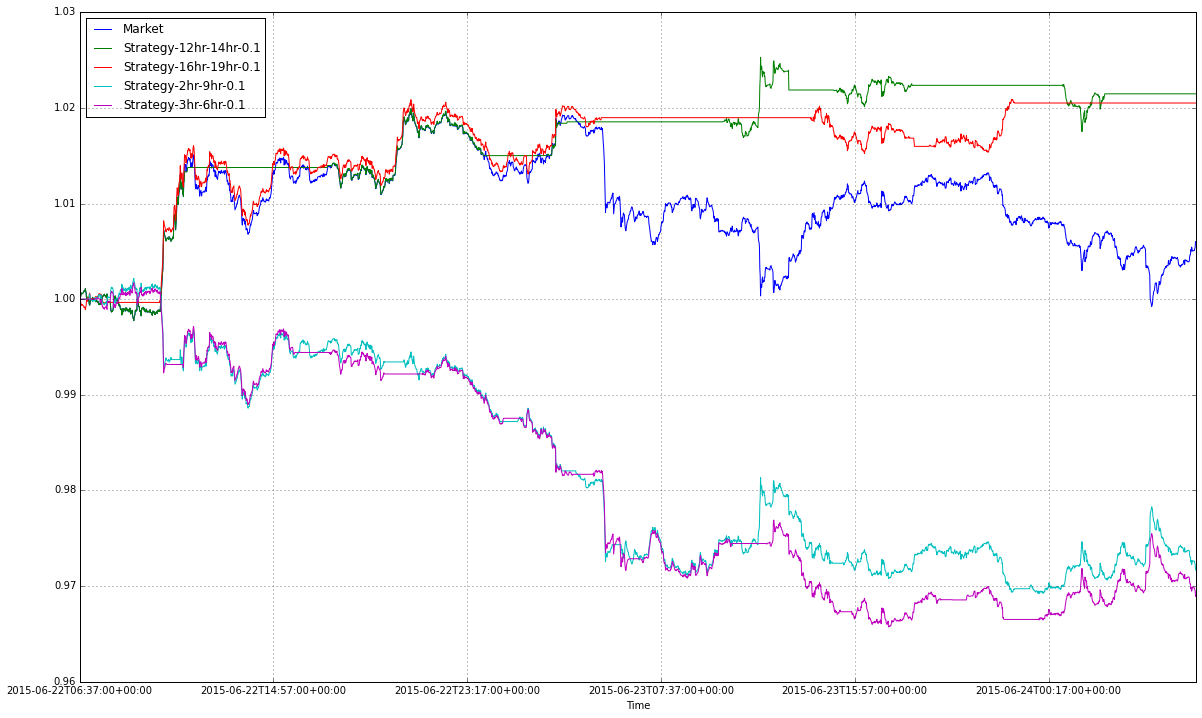

In [10]:
last_24 = df[-2880:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])
column_names = ['Market']+last_24[:2].index.tolist()+last_24[-2:].index.tolist()
plotb = df[-2880:][column_names].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))

In [34]:
class StrategySelector():
    def __init__(self, dataframe, name, means, sds):
        self.dataframe = dataframe
        self.current_strategy=None
        self.means = means
        self.create_means()
        self.set_market()
        self.available_stategies = [Name(means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
        for name in regime_and_strategy_names:
            self.create_diff(name)
            self.create_regime(name)
            self.create_strategy(name)
    
    def strategies(self):
        return self.dataframe[[n.strategies for n in self.available_stategies]]
    def create_means(self):
        for mean in self.means:
            self.dataframe[str(mean)+"hr"] = np.round(pd.rolling_mean(df['Value'], window=mean*60), 2)

    def create_diff(self, name):
            self.dataframe[name.name] = self.dataframe[name.mean1] - self.dataframe[name.mean2]

    def create_regime(self, name):
        self.dataframe[name.regime] = np.where(self.dataframe[name.name] > name.sd, 1, 0)
        self.dataframe[name.regime] = np.where(self.dataframe[name.name] < -name.sd, -1, self.dataframe[name.regime])

    def set_market(self):
        self.dataframe['Market'] = np.log(self.dataframe['Value']/ self.dataframe['Value'].shift(1))
        self.dataframe['Market-cumulative'] = self.dataframe['Market'].cumsum().apply(np.exp)

    def create_strategy(self, name):
        self.dataframe[name.strategy] = self.dataframe[name.regime].shift(5) * self.dataframe['Market']
    
    def select_on_time_performance(hours=1):
        dataframe2= self.strategies.cumsum().apply(np.exp) - self.strategies.cumsum().apply(np.exp).shift(hours*60)
        
        #self.dataframe['best_{}_hours'.format(hours)] = self.dataframe[]
        last_24 = df[-2880:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])

class Name():
    def __init__(self, means, sd):
        self.mean1 = str(means[0])+"hr"
        self.mean2 = str(means[1])+"hr"
        self.name = self.mean1+"-"+self.mean2
        self.sd = sd
        self.strategy = "Strategy-{}-%.1f".format(self.name) % sd
        self.regime = "Regime-{}-%.1f".format(self.name) % sd
        self.cumsum = "Cumulative-{}-%.1f".format(self.name) % sd
    
    @classmethod
    def from_strategy_name(cls, strat):
        parts = strat.split('-')
        return cls([p.rstrip("hr") for p in parts[1:3]],float(parts[3]))

class Strategy():
    def __init__(self, dataset, means, sd):
        self.name = Name(means, sd)
        self.dataset = pd.DataFrame(dataset[['Market',self.name.mean1, self.name.mean2]])
        self.dataset['Difference']= self.dataset[self.name.mean1] - self.dataset[self.name.mean2]
        self.dataset['Regime'] = np.where(self.dataset[name.name] > name.sd, 1, 0)
        self.dataset['Regime'] = np.where(self.dataset[name.name] < -name.sd, -1, self.dataset['Regime'])
    
    def strategy(self, timeframe):
        self.dataset['Strategy'] = self.dataframe[name.regime].shift(strategy) * self.dataframe['Market']
        return self.dataset['Market','Strategy']

st = Strategy(df, [1,3], 0.3)
st.strategy(60).tail()

KeyError: '22hr-23hr'

# Next, I want to see what the best performing strategy is every day
## So first I'll add a column to our dataset called day_best